In [25]:
import random
import pickle
import multiprocessing
import sqlite3
import tempfile
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import AllChem

from rad.hnsw_service import create_local_hnsw_service
from rad.traverser import RADTraverser
from usearch.index import Index

# Disable rdkit error logging to keep output clean
RDLogger.DisableLog('rdApp.*')

In [26]:
# Set the number of workers for fingerprint generation and HNSW traversal
N_WORKERS = 8

### Load the DUDEZ DOCK dataset

In [ ]:
!curl -O https://zenodo.org/records/10989077/files/dudez_dock_scores.pkl

In [27]:
with open('dudez_dock_scores.pkl', 'rb') as f:
    data_list = [
        (zid, smiles, score)
        for zid, (smiles, score) in pickle.load(f).items()
    ]

# Shuffle the data
random.shuffle(data_list)

Loaded 100000 molecules from DUDEZ dataset


### Set parameters for fingerprints and generate them

In [29]:
FP_LENGTH = 1024
FP_RADIUS = 2

In [30]:
def generate_fingerprint(args):
    zid, smi, scores = args
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=FP_RADIUS, nBits=FP_LENGTH)
    arr = np.zeros((FP_LENGTH,), dtype=np.uint8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return np.packbits(arr), smi, scores  # Return fingerprint, SMILES, and scores dict

In [31]:
with multiprocessing.Pool(N_WORKERS) as p:
    results = list(tqdm(p.imap(generate_fingerprint, data_list), total=len(data_list), desc="Generating Fingerprints"))

# Filter molecules that failed fingerprint generation
results = list(filter(None, results))

# Format fingerprints and create keys for HNSW
fps, smiles_list, scores_list = zip(*results)
fps = np.vstack(fps)
keys = np.arange(len(fps))

# Create SMILES → scores mapping for use in the scoring function
smiles_to_scores = {}
for i, (smiles, scores_dict) in enumerate(zip(smiles_list, scores_list)):
    smiles_to_scores[smiles] = scores_dict

Generating Fingerprints: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:15<00:00, 6349.70it/s]


Generated 99998 fingerprints with SMILES and scores
Created mapping for 99981 unique SMILES molecules


### Set parameters for HNSW and construct it

In [43]:
EF_CONSTRUCTION = 400
M = 16

In [44]:
hnsw = Index(
    ndim = FP_LENGTH,
    dtype='b1',
    metric='tanimoto',
    connectivity = M,
    expansion_add = EF_CONSTRUCTION
)

# Add fingerprints to HNSW index
hnsw.add(keys, fps, log="Building HNSW")

Added 99998 fingerprints to HNSW index


### Create SQLite database mapping HNSW nodes to SMILES

In [45]:
# Create SQLite database for SMILES lookup
db_path = "dudez_molecules.db"
if os.path.exists(db_path):
    os.remove(db_path)

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Create nodes table
cursor.execute("""
    CREATE TABLE nodes (
        node_key INTEGER PRIMARY KEY,
        smi TEXT NOT NULL
    )
""")

# Insert SMILES data matching HNSW keys 
for node_key, smiles in zip(keys, smiles_list):
    cursor.execute("INSERT INTO nodes (node_key, smi) VALUES (?, ?)", (int(node_key), str(smiles)))

# Create index for performance
cursor.execute("CREATE INDEX idx_nodes_node_id ON nodes(node_key)")

conn.commit()
conn.close()

Created SQLite database 'dudez_molecules.db' with 99998 SMILES entries
Database maps HNSW keys (stored as node_id) → SMILES
HNSW keys range: 0 to 99997


### Define SMILES-Based Scoring Function

In [ ]:
RECEPTOR = "AA2AR"

In [46]:
def score_fn(smiles: str) -> float:
    """
    Score a molecule using its SMILES representation and actual DUDEZ scores.
    
    Args:
        smiles: SMILES string representing the molecular structure
        
    Returns:
        float: Actual docking score for the receptor from DUDEZ dataset (lower is better)
    """
    # Look up the actual scores for this SMILES
    if smiles in smiles_to_scores:
        scores_dict = smiles_to_scores[smiles]
        if RECEPTOR in scores_dict:
            return scores_dict[RECEPTOR]
    
    # Return high score (bad) if no score found
    return 9999.0

Testing scoring function:
SMILES: CC1=C(C(=O)N[C@H](C)C2=NC3=CC=CC=C3N2)CCO1
Score for AA2AR: -24.106894
Available receptors: ['AA2AR', 'ADA', 'CXCR4', 'EGFR', 'FABP4', 'GLCM', 'HMDH', 'KIT', 'MAPK2', 'NRAM', 'PLK1', 'PUR2', 'TRYB1', 'ABL1', 'ADRB2', 'D4', 'FA10', 'FGFR1', 'HDAC8', 'HS90A', 'KITH', 'MK01', 'PARP1', 'PPARA', 'RENI', 'THRB', 'UROK', 'ACES', 'AMPC', 'CSF1R', 'DEF', 'FA7', 'FKB1A', 'HIVPR', 'ITAL', 'LCK', 'MT1', 'PTN1', 'ROCK1', 'SRC', 'TRY1', 'XIAP']


### Set up the HNSW service, RADTraverser, and do the traversal

In [ ]:
# Create HNSW service that serves neighbor smiles for traversal
hnsw_service = create_local_hnsw_service(hnsw, database_path=db_path)

In [47]:
# Create traverser with scoring function
traverser = RADTraverser(hnsw_service=hnsw_service, scoring_fn=score_fn)

Redis server not start yet - waiting 1 second
RADTraverser created with SMILES integration


In [48]:
# "Prime" the traversal - initialize queue with top layer nodes
traverser.prime()

In [49]:
# Do the traversal
NUM_TO_TRAVERSE = 100_000
traverser.traverse(n_workers=N_WORKERS, n_to_score=NUM_TO_TRAVERSE)

Error in coordination monitor: cannot join current thread


### Graph Enrichment Plots

In [ ]:
VIRTUAL_ACTIVE_CUTOFF = 100

In [50]:
receptor_scores = []
for node_key, node_scores in enumerate(scores_list):
    if RECEPTOR in node_scores:
        receptor_scores.append((node_key, node_scores[RECEPTOR]))  # (array_index, score)
    else:
        receptor_scores.append((node_key, 9999))

receptor_scores.sort(key=lambda x: x[1])

# Get the best scoring node keys and convert to node ids
best_keys = [array_index for array_index, _ in receptor_scores[:VIRTUAL_ACTIVE_CUTOFF]]
best_node_ids = hnsw.get_node_ids_from_keys(best_keys)
virtual_actives = set(best_node_ids)

Virtual actives (top 1000 molecules):
Best score: -42.32
Worst score in top 1000: -32.21
Virtual actives array indices (keys): [3561, 27251, 35152, 36491, 52345, 56568, 62644, 66970, 86727, 96758]...
Virtual actives node_ids: [np.int64(261), np.int64(301), np.int64(507), np.int64(587), np.int64(686), np.int64(832), np.int64(928), np.int64(1003), np.int64(1093), np.int64(1211)]...


In [51]:
# Get all scored molecules in traversal order
all_results = traverser.get_molecules()

x = []  # Number of molecules traversed
y = []  # Number of virtual actives found
mols_traversed = 0
va_found = 0

for node_id, score, smiles in all_results:
    mols_traversed += 1
    if node_id in virtual_actives:
        va_found += 1
    x.append(mols_traversed)
    y.append(va_found)

# Convert to fraction of library and fraction of virtual actives
total_molecules = len(hnsw)
x_fraction = np.array(x) / total_molecules
y_fraction = np.array(y) / VIRTUAL_ACTIVE_CUTOFF

Analyzing 25218 scored molecules in traversal order...
Found 766/1000 virtual actives in 25218 scored molecules
Final enrichment: 76.6% of virtual actives found


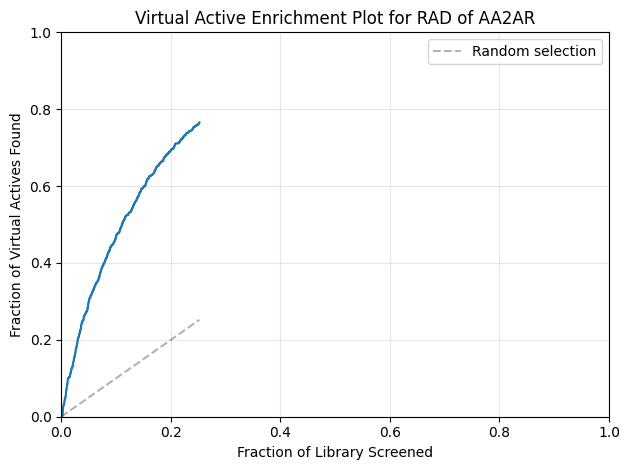

Total library size: 99,998 molecules
Fraction of library screened: 25.22%


In [54]:
plt.plot(x_fraction, y_fraction)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Fraction of Library Screened")
plt.ylabel("Fraction of Virtual Actives Found")
plt.title(f"Enrichment Plot for RAD of {RECEPTOR}")
plt.grid(True, alpha=0.3)

random_baseline = x_fraction
plt.plot(x_fraction, random_baseline, 'k--', alpha=0.3, label='Random selection')

plt.tight_layout()
plt.show()

### Cleanup: Shutdown services and remove database

In [42]:
# Shutdown RAD traverser (closes HNSW service and Redis)
traverser.shutdown()

# Optional: Clean up database file
if os.path.exists(db_path):
    os.remove(db_path)
    print(f"Removed database file: {db_path}")

print("RAD traverser shut down successfully")

Removed database file: dudez_molecules.db
RAD traverser shut down successfully
